In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import fitsio
import pylab               as     pl
import numpy               as     np
import matplotlib.pyplot   as     plt
import astropy.io.fits     as     fits
import matplotlib          as     mpl
import astropy.units       as     u

from   astropy.table       import Table, join, unique
from   astropy.coordinates import SkyCoord
from   scipy.spatial       import Voronoi, voronoi_plot_2d

In [3]:
sys.path.append(os.environ['HOME'])
sys.path.append(os.environ['HOME'] + '/DESI/')

In [4]:
import pubplot

from   cosmo         import cosmo, fsky, distcom
from   cartesian     import rotate
from   findfile      import findfile
from   poisson       import fillfactor_expectation, fillfactor_poisson
from   ddp_zlimits   import ddp_zlimits
from   fillfactor    import collate_fillfactors

In [5]:
def PolyArea(x,y):
    return  0.5 * np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [7]:
photoz = Table.read('/cosma/home/durham/dc-wils7/data/EAZYPhotoZv02.fits')

In [8]:
sci = Table.read('/cosma/home/durham/dc-wils7/data/gkvScienceCatv02.fits')
sci = sci[sci['SC'] >= 7] # r_KIDS < 19.65
sci = sci[sci['NQ'] >= 3]
sci.sort('uberID')
sci

uberID,RAcen,Deccen,RAmax,Decmax,RAGAIA,DecGAIA,sky_mean,skyRMS_mean,log10seeing,EBV,mag,R50,R90,R100,N100,axrat,ang,flux_FUVt,flux_FUVl,flux_err_FUVt,flux_NUVt,flux_NUVl,flux_err_NUVt,flux_ut,flux_ul,flux_err_ut,flux_gt,flux_gl,flux_err_gt,flux_rt,flux_rl,flux_err_rt,flux_it,flux_il,flux_err_it,flux_Zt,flux_Zl,flux_err_Zt,flux_Yt,flux_Yl,flux_err_Yt,flux_Jt,flux_Jl,flux_err_Jt,flux_Ht,flux_Hl,flux_err_Ht,flux_Kt,flux_Kl,flux_err_Kt,flux_W1t,flux_W1l,flux_err_W1t,flux_W2t,flux_W2l,flux_err_W2t,duplicate,mask,starmask,uberclass,CATAID,SC,Z,NQ
,deg,deg,deg,deg,deg,deg,Jy,Jy,log(arcsec),mag,mag,arcsec,arcsec,arcsec,,,deg,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,int16,int32,int16,float32,int16
128980003711188,129.579930278292,-1.02978043903405,129.579932683367,-1.02978364542057,129.579917127811,-1.0298019787539,-3.2522729e-13,3.9659894e-12,-0.25130096,0.039404288,17.2534,2.0644488,5.534397,12.665411,2359,0.5379462,14.949414,3.7622426e-06,1.8775262e-06,6.592376e-08,1.8948501e-06,4.639499e-07,1.783146e-07,3.1354277e-05,2.9739422e-05,2.3111963e-06,0.00017459311,0.00017035949,8.010887e-07,0.0004252589,0.00041564586,9.38886e-07,0.00063660165,0.0006154055,4.277399e-06,0.0008387682,0.00080726604,2.8500554e-06,0.0010912559,0.0010391885,4.318675e-06,0.0012729218,0.0012607822,6.7473425e-06,0.0016559247,0.0015765553,1.0185171e-05,0.0014912887,0.0014136028,1.1099676e-05,0.00076479634,0.0006932739,4.308207e-06,0.00041533215,0.00038133233,9.162291e-06,False,False,False,1,3600151,8,0.08185,4
128980004608892,129.579120957998,-1.24600373591109,129.57914237232902,-1.24597052992676,129.579126816773,-1.2459888632601,-6.235091e-13,4.45304e-12,-0.25130096,0.03663875,19.62488,1.4528091,2.7260127,3.5369992,246,0.71930766,24.843025,5.9163476e-06,1.5420331e-06,9.390429e-09,5.678131e-06,4.9415416e-06,1.072075e-07,1.3446274e-05,1.1603522e-05,7.3411456e-07,2.4912522e-05,2.1897316e-05,2.4025044e-07,5.027862e-05,4.645822e-05,3.0774183e-07,6.4226166e-05,5.7130877e-05,5.5112065e-07,7.798098e-05,7.505486e-05,6.6790915e-07,8.846863e-05,8.5702704e-05,1.5427186e-06,9.43052e-05,8.2926155e-05,2.7346246e-06,0.00011900299,0.00012463274,4.1954318e-06,0.0001302289,0.00011556382,4.5622137e-06,0.00010702925,8.509128e-05,8.0250607e-07,5.0995783e-05,5.126498e-05,6.123744e-07,False,False,False,1,3874273,7,0.30551,4
128980005210530,129.578549016984,-1.09171591981672,129.578536525687,-1.09173876283465,129.578520970131,-1.09175709616798,-1.9836392e-13,4.022541e-12,-0.25130096,0.03914747,18.26186,1.9691488,6.204499,9.950718,2356,0.87039423,70.918526,7.3471238e-06,-2.4907516e-08,8.244568e-08,1.1259933e-06,-1.0256644e-07,1.5518829e-07,6.6233483e-06,9.19258e-06,1.742145e-06,4.3395437e-05,4.187161e-05,7.553113e-07,0.00016725504,0.00015794583,1.5254071e-06,0.00025626548,0.00025793092,1.790889e-06,0.0003574356,0.0003447857,2.2677946e-06,0.0004627444,0.00042919506,5.314643e-06,0.0005765088,0.00058888376,7.3797073e-06,0.00087760214,0.0007020546,2.6406551e-05,0.0009705686,0.00092936575,1.230545e-05,0.00048209692,0.0004506983,2.3163009e-06,0.00032877963,0.00026765966,8.127045e-06,False,False,False,1,3600249,8,0.28994,4
128980005309861,129.578474121309,-1.15473342154572,129.57845900453998,-1.1547303401663502,129.578443448984,-1.15474867349968,-1.9509249e-13,4.1204718e-12,-0.25130096,0.03815698,19.45848,1.9135718,3.8647137,5.6677957,511,0.5818916,19.881395,1.15e-05,5.6613226e-06,8.696644e-08,4.482213e-06,3.6730312e-06,6.714967e-08,1.1671629e-05,9.862621

In [9]:
sci = join(sci, photoz, join_type='left', keys='uberID')

Text(0, 0.5, 'DEC [deg.]')

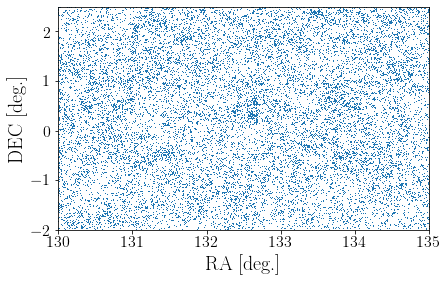

In [10]:
pl.plot(sci['RAcen'], sci['Deccen'], marker=',', lw=0.0)

pl.xlim(130., 135.)
pl.ylim(-2.,   2.5)

pl.xlabel('RA [deg.]')
pl.ylabel('DEC [deg.]')

In [14]:
isin  = (sci['Deccen'] > -2.0)
isin &= (sci['Deccen'] <  2.0)
isin &= (sci['RAcen']  > 130.)
isin &= (sci['RAcen']  < 134.)

sci   = sci[isin]
sci

uberID,RAcen,Deccen,RAmax,Decmax,RAGAIA,DecGAIA,sky_mean,skyRMS_mean,log10seeing,EBV,mag,R50,R90,R100,N100,axrat,ang,flux_FUVt,flux_FUVl,flux_err_FUVt,flux_NUVt,flux_NUVl,flux_err_NUVt,flux_ut,flux_ul,flux_err_ut,flux_gt,flux_gl,flux_err_gt,flux_rt,flux_rl,flux_err_rt,flux_it,flux_il,flux_err_it,flux_Zt,flux_Zl,flux_err_Zt,flux_Yt,flux_Yl,flux_err_Yt,flux_Jt,flux_Jl,flux_err_Jt,flux_Ht,flux_Hl,flux_err_Ht,flux_Kt,flux_Kl,flux_err_Kt,flux_W1t,flux_W1l,flux_err_W1t,flux_W2t,flux_W2l,flux_err_W2t,duplicate,mask,starmask,uberclass,CATAID_1,SC,Z,NQ,CATAID_2,all_primary,science_primary,star_primary,nfilt,z_peak,peak_prob,chi2_fit,fitflux_u,fitflux_g,fitflux_r,fitflux_i,fitflux_Z,fitflux_Y,fitflux_J,fitflux_H,fitflux_K,z_1,chi2_1,temp_1,z_m1,z_p,chi2_p,temp_p,z_m2,z_mc,l68,u68,l95,u95,l99,u99,odds,Qz
,deg,deg,deg,deg,deg,deg,Jy,Jy,log(arcsec),mag,mag,arcsec,arcsec,arcsec,,,deg,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,int16,int32,int16,float32,int16,int32,bool,bool,bool,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
129980010706612,130.573457870055,-1.46073275858253,130.573453744232,-1.4606593753345,130.573438188676,-1.46067770866783,-1.3957646e-12,4.091705e-12,-0.21480854,0.03678473,19.141712,2.2412927,4.5785937,7.6182075,771,0.4859575,171.5484,1.8775914e-05,1.7034567e-05,8.332097e-08,1.5110067e-05,1.4594849e-05,1.530182e-07,2.1347962e-05,2.040285e-05,1.000748e-06,5.935096e-05,5.6521763e-05,4.1723882e-07,8.192321e-05,7.8915e-05,5.2436167e-07,0.000104148516,0.00010384664,1.3761182e-06,0.000111932495,0.00010984605,1.2393679e-06,0.00012901853,0.00011563948,2.4512872e-06,0.000115055176,0.00012925484,4.3080013e-06,0.00010868858,0.00017188267,7.783908e-06,0.00013614589,0.00016986736,8.295606e-06,6.992865e-05,5.9425834e-05,8.8233594e-07,1.4143345e-05,2.7285865e-05,9.589933e-07,False,False,False,1,3578329,8,0.08218,4,3578329,True,True,False,9,0.06568623,1.0,18.715342,2.232221e-05,5.9611848e-05,7.863037e-05,9.7044016e-05,0.00011029359,0.00012572687,0.00012497681,0.00013960116,0.00013087437,0.053166185,18.02968,24,0.06,0.053166185,18.02968,24,0.065708205,0.0567,0.044,0.089,0.033,0.109,0.022,0.129,1.0,0.335094
129980012101904,130.572335913085,-1.904034100009,130.572251053251,-1.90396757029708,130.572235497696,-1.90398590363042,-4.6790545e-13,4.129585e-12,-0.21480854,0.03856791,19.36115,1.4547489,3.8414307,6.449546,942,0.82840395,36.651016,4.2805127e-06,4.3612713e-06,6.7260395e-08,3.3529006e-06,3.5436117e-06,1.1579065e-07,5.77295e-06,-1.0313689e-06,1.1620041e-06,2.227623e-05,1.9796178e-05,4.2804686e-07,6.4516986e-05,6.183063e-05,7.293705e-07,9.378448e-05,8.217368e-05,1.5904293e-06,0.00012819204,0.00011929531,1.7115235e-06,0.00014967428,0.00014789018,2.8265188e-06,0.00018411243,0.00021395308,5.7284633e-06,0.0002334647,0.00021823483,1.1220206e-05,0.0003024155,0.00027727292,9.65601e-06,0.00013930238,0.0001225499,1.4766243e-06,6.814529e-05,7.084898e-05,1.1557621e-06,False,False,False,1,3554696,8,0.2617,4,3554696,True,True,False,9,0.2914267,1.0,4.460593,7.571509e-06,2.2644923e-05,6.367421e-05,9.240583e-05,0.00012671345,0.00015159819,0.00019350823,0.00022957944,0.0002907268,0.3059642,3.9722,15,0.293,0.3059642,3.9722,15,0.2914754,0.3033,0.238,0.33,0.177,0.368,0.13,0.402,1.0,0.2

In [15]:
c                              = SkyCoord(ra=sci['RAcen'], dec=sci['Deccen'])

In [16]:
uids, cnts                     = np.unique(sci['uberID'].data, return_counts=True)

In [19]:
nneighbour = 25000

neighbours = []

for i, uid in enumerate(uids):
    # Centering point
    catalog                    = SkyCoord(ra=[sci['RAcen'][i] * u.deg], dec=[sci['Deccen'][i] * u.deg])

    idxc, idxcatalog, d2d, d3d = catalog.search_around_sky(c, 10. * u.arcmin)

    matches                    = c[idxc][d2d > 2. * u.arcsec]
    ids                        = sci['uberID'][idxc][d2d > 2. * u.arcsec]
    zs                         = sci['Z'][idxc][d2d > 2. * u.arcsec]

    d2d                        = d2d[d2d > 2. * u.arcsec]
    
    idxs                       = np.argsort(d2d)
    idx                        = idxs[0]
    
    neighbor                   = matches[idx]
    uberID                     = ids[idx]
    separation                 = d2d[idx].arcsec
    zz                         = zs[idx]
    
    zbias                      = np.abs(sci['Z'][i] - zz)
    
    # print(sci['uberID'][i], uberID, separation)
        
    neighbours.append([sci['uberID'][i], sci['Z'][i], uberID, zz, separation, zbias])
    
    if i > nneighbour:
        break
        
    else:
        if (i % 100) == 0:
            print(100. * i / len(uids))
            
dt         = np.dtype([('uberID', np.int), ('Separation', np.float64)])
    
neighbours = np.array(neighbours)
neighbours = Table(neighbours, names=['uberID', 'Z', 'match_uberID', 'match_Z', 'separation', 'zbias'])

0.0
0.7841907151819323
1.5683814303638646
2.3525721455457966
3.136762860727729
3.920953575909661
4.705144291091593
5.489335006273525
6.273525721455458
7.05771643663739
7.841907151819322
8.626097867001254
9.410288582183187
10.194479297365119
10.97867001254705
11.762860727728985
12.547051442910917
13.331242158092849
14.11543287327478
14.899623588456713
15.683814303638645
16.468005018820577
17.25219573400251
18.03638644918444
18.820577164366373
19.604767879548305
20.388958594730237
21.17314930991217
21.9573400250941
22.741530740276033
23.52572145545797
24.3099121706399
25.094102885821833
25.878293601003765
26.662484316185697
27.44667503136763
28.23086574654956
29.015056461731493
29.799247176913426
30.583437892095358
31.36762860727729
32.151819322459225
32.936010037641154
33.72020075282309
34.50439146800502
35.28858218318695
36.07277289836888
36.85696361355082
37.641154328732746
38.42534504391468
39.20953575909661
39.993726474278546
40.777917189460474
41.56210790464241
42.34629861982434
43

/tmp/ipykernel_162075/3109351175.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dt         = np.dtype([('uberID', np.int), ('Separation', np.float64)])


In [29]:
neighbours           = join(neighbours, sci['uberID', 'z_peak'], join_type='left', keys='uberID')
neighbours['zpbias'] = np.abs(neighbours['Z'] - neighbours['z_peak'])
neighbours['zp_zn']  = np.abs(neighbours['match_Z'] - neighbours['z_peak'])
neighbours

uberID,Z,match_uberID,match_Z,separation,zbias,zpbias,z_peak,zp_zn
float64,float64,float64,float64,float64,float64,float64,float32,float64
129980010706612.0,0.08218000084161758,129980013906596.0,0.18483999371528625,12.032272928575031,0.10265999287366867,0.016493767499923706,0.06568623,0.11915376037359238
129980012101904.0,0.26170000433921814,130981103002033.0,0.2609899938106537,109.30635676102735,0.0007100105285644531,0.029726684093475342,0.2914267,0.030436694622039795
129980013906596.0,0.18483999371528625,129980010706612.0,0.08218000084161758,12.032272928575052,0.10265999287366867,0.0024166852235794067,0.18725668,0.10507667809724808
129980016503869.0,0.2690800130367279,130981085703835.0,0.268559992313385,28.531166722889907,0.0005200207233428955,0.0385931134223938,0.2304869,0.0380730926990509
129980020901415.0,0.35095998644828796,130981083401380.0,0.3513999879360199,12.683192085287773,0.0004400014877319336,0.04891517758369446,0.3020448,0.04935517907142639
129980024708199.0,0.10786999762058258,130981108808610.0,0.2097799926996231,158.41583364024495,0.10190999507904053,0.02108420431613922,0.08678579,0.12299419939517975
129980030802902.0,0.20952999591827393,130981097402907.0,0.21100999414920807,17.532297845418626,0.001479998230934143,0.0007174462080001831,0.21024744,0.00076255202293396
129980030804519.0,0.18501999974250793,130981115804750.0,0.2709699869155884,111.61566141177248,0.08594998717308044,0.02915823459625244,0.15586177,0.11510822176933289
129980034302756.0,0.21059000492095947,129980040002824.0,0.20994000136852264,30.08044663501943,0.0006500035524368286,0.004389733076095581,0.20620027,0.0037397295236587524


In [31]:
points    = [[xx['RAcen'], xx['Deccen']] for xx in sci]

In [32]:
vor       = Voronoi(points)

In [33]:
# fig     = voronoi_plot_2d(vor)

In [34]:
inv_areas = -99. * np.ones(len(points))

for i, region in enumerate(vor.regions):
    xx    = vor.vertices[region][:,0]
    yy    = vor.vertices[region][:,1]
    
    AA    = PolyArea(xx,yy)
    
    isin  = (vor.point_region == i)
    
    inv_areas[isin] = 1. / AA
    
    # print('{:d}\t{:.6f}'.format(i, AA))

/tmp/ipykernel_162075/1289132122.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  inv_areas[isin] = 1. / AA


In [36]:
neighbours['density'] = inv_areas

Text(0.5, 0, 'Inv. Voronoi area')

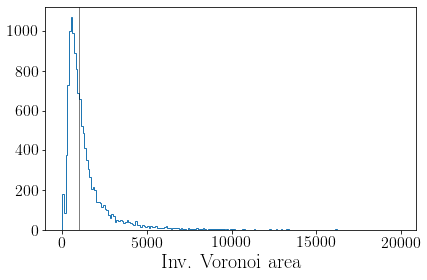

In [37]:
_ = pl.hist(inv_areas, bins=np.arange(0.0, 2.e4, 1.e2), histtype='step')

pl.axvline(1000, c='k', lw=0.5)
pl.xlabel('Inv. Voronoi area')

Text(0, 0.5, 'Neighbour $z$')

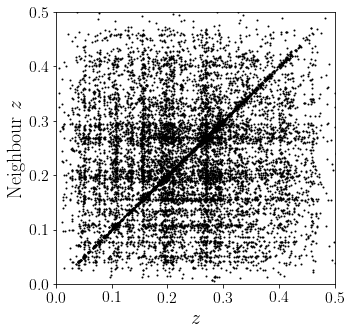

In [72]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

isin    = neighbours['separation'] > 0.

ax.plot(neighbours['Z'][isin], neighbours['match_Z'][isin], marker='.', lw=0.0, markersize=2, c='k', alpha=1.)

ax.set_xlim(0.0, 0.5)
ax.set_ylim(0.0, 0.5)

ax.set_xlabel('$z$')
ax.set_ylabel('Neighbour $z$')

(-2.0, 2.0)

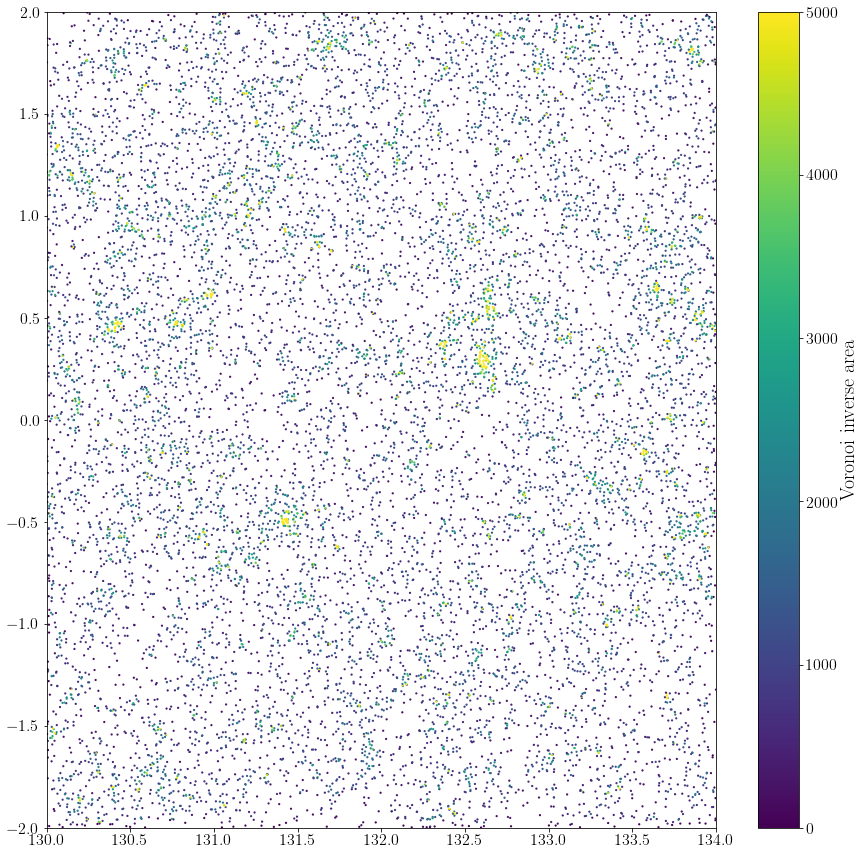

In [41]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
'''
for ii, ridge in enumerate(vor.ridge_vertices):
    ax.plot(vor.vertices[ridge][:,0], vor.vertices[ridge][:,1], c='k', lw=0.5)
'''
sc      = ax.scatter(np.array(points)[:,0],\
                     np.array(points)[:,1],\
                     c=inv_areas,\
                     marker='.',\
                     lw=0.0,\
                     s=20,\
                     vmin=0.0,\
                     vmax=5.e3)

pl.colorbar(sc, label='Voronoi inverse area')

pl.xlim(130., 134.)
pl.ylim(-2.,    2.)

Text(0.5, 0, '$\\Delta z$')

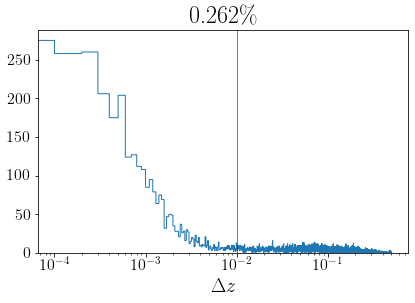

In [131]:
bins = np.arange(0.0, 0.5, 1.e-4)
_    = pl.hist(neighbours['zbias'], bins=bins, histtype='step')

pl.title('{:.3f}\%'.format(np.mean(neighbours['zbias'] < 0.01), 0.01))

pl.axvline(0.01, c='k', lw=0.5)

pl.xscale('log')
pl.xlabel(r'$\Delta z$')

/tmp/ipykernel_162075/1031388817.py:5: RuntimeWarning: divide by zero encountered in log10
  c=np.log10(neighbours['zbias']),\


(-2.0, 2.0)

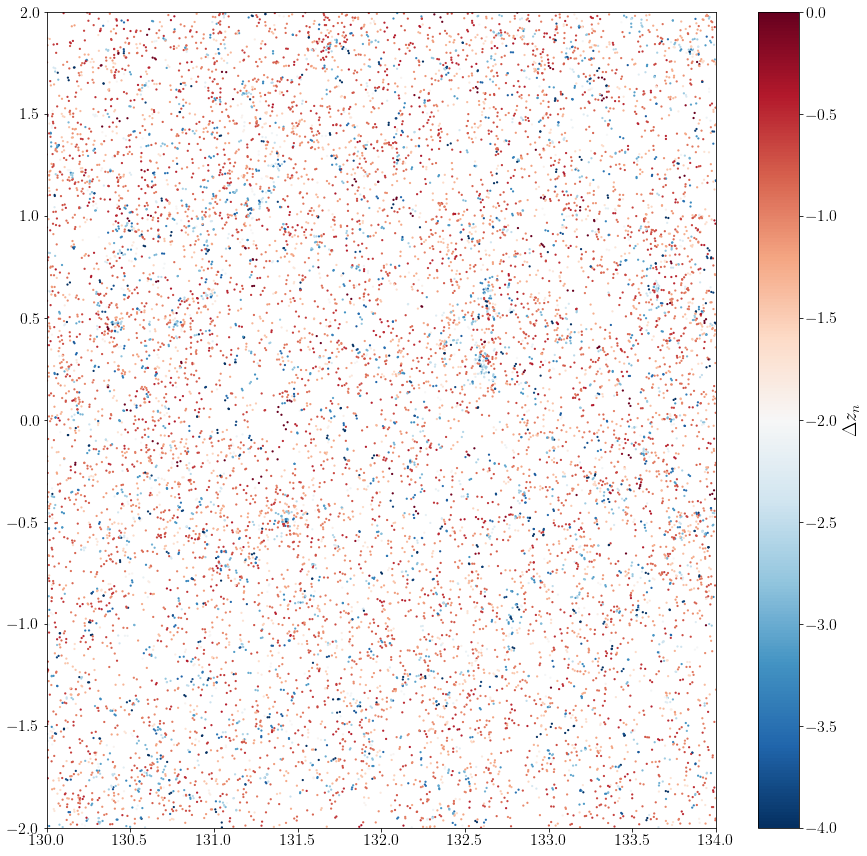

In [135]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

sc      = ax.scatter(np.array(points)[:,0],\
                     np.array(points)[:,1],\
                     c=np.log10(neighbours['zbias']),\
                     marker='.',\
                     lw=0.0,\
                     s=20,\
                     vmin=-4.,\
                     vmax=0.,\
                     cmap='RdBu_r')

pl.colorbar(sc, label=r'$\Delta z_n$')

pl.xlim(130., 134.)
pl.ylim(-2.,    2.)

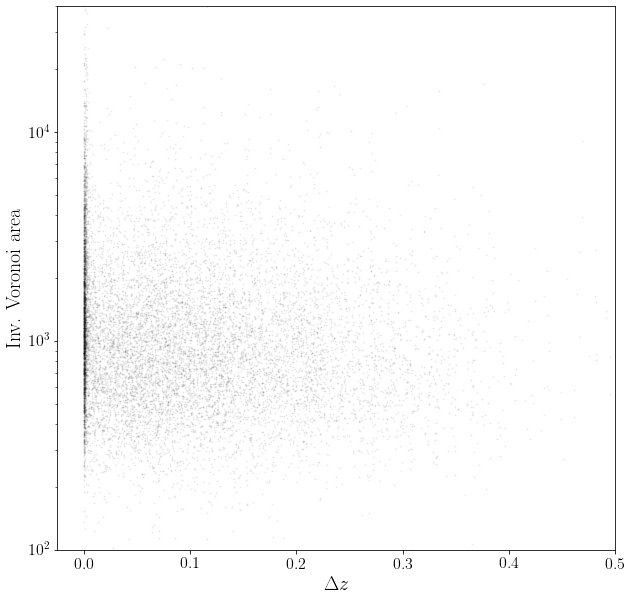

In [46]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
isin    = neighbours['separation'] > 0.

sc      = ax.scatter(neighbours['zbias'][isin],\
                     inv_areas[isin],\
                     marker='.',\
                     lw=0.0,\
                     s=12,\
                     c='k',\
                     alpha=0.1,\
                     vmin=0.,\
                     vmax=5.e3)

ax.set_xlim(-0.025, 5.e-1)
ax.set_ylim(100.,    4.e4)

ax.set_xlabel(r'$\Delta z$')
ax.set_ylabel('Inv. Voronoi area')

# ax.set_xscale('log')
ax.set_yscale('log')

In [48]:
neighbours

uberID,Z,match_uberID,match_Z,separation,zbias,zpbias,z_peak,zp_zn,density
float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
129980010706612.0,0.08218000084161758,129980013906596.0,0.18483999371528625,12.032272928575031,0.10265999287366867,0.016493767499923706,0.06568623,0.11915376037359238,766.185728220665
129980012101904.0,0.26170000433921814,130981103002033.0,0.2609899938106537,109.30635676102735,0.0007100105285644531,0.029726684093475342,0.2914267,0.030436694622039795,473.1638666260282
129980013906596.0,0.18483999371528625,129980010706612.0,0.08218000084161758,12.032272928575052,0.10265999287366867,0.0024166852235794067,0.18725668,0.10507667809724808,545.2087461616323
129980016503869.0,0.2690800130367279,130981085703835.0,0.268559992313385,28.531166722889907,0.0005200207233428955,0.0385931134223938,0.2304869,0.0380730926990509,2013.675236762808
129980020901415.0,0.35095998644828796,130981083401380.0,0.3513999879360199,12.683192085287773,0.0004400014877319336,0.04891517758369446,0.3020448,0.04935517907142639,1169.5589496053515
129980024708199.0,0.10786999762058258,130981108808610.0,0.2097799926996231,158.41583364024495,0.10190999507904053,0.02108420431613922,0.08678579,0.12299419939517975,276.99825813997336
129980030802902.0,0.20952999591827393,130981097402907.0,0.21100999414920807,17.532297845418626,0.001479998230934143,0.0007174462080001831,0.21024744,0.00076255202293396,1499.5619192294312
129980030804519.0,0.18501999974250793,130981115804750.0,0.2709699869155884,111.61566141177248,0.08594998717308044,0.02915823459625244,0.15586177,0.11510822176933289,471.7093823223517
129980034302756.0,0.21059000492095947,129980040002824.0,0.20994000136852264,30.08044663501943,0.0006500035524368286,0.004389733076095581,0.20620027,0.0037397295236587524,1152.4989252796508


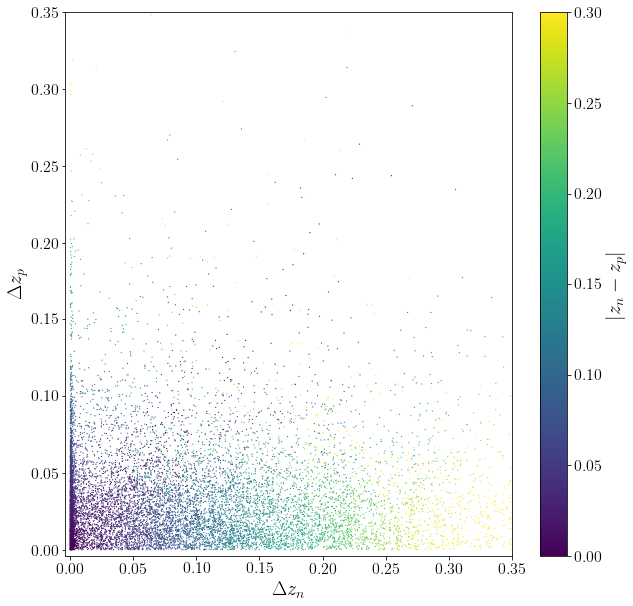

In [122]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

# ax.axvline(0.05, c='k', lw=0.5)

thetas = np.arange(0.0, np.pi/2., 1.e-3) 
rs     = 0.1 * np.ones_like(thetas)

xs     = rs * np.cos(thetas)
ys     = rs * np.sin(thetas)

# pl.plot(xs, ys, c='k', lw=1.)

sc = ax.scatter(neighbours['zbias'],\
                neighbours['zpbias'],\
                marker='.',\
                lw=0.0,\
                s=6,\
                c=neighbours['zp_zn'],\
                alpha=1.,\
                vmin=0.0,\
                vmax=0.3)

ax.set_xlim(-4.e-3,  0.35)
ax.set_ylim(-4.e-3,  0.35)

ax.set_xlabel('$\Delta z_n$')
ax.set_ylabel('$\Delta  z_p$')

# ax.set_xscale('log')
# ax.set_yscale('log')

pl.colorbar(sc, label=r'$|z_n - z_p|$')

In [125]:
np.mean((neighbours['zp_zn'] < 0.05) | (neighbours['zpbias'] < 0.05))

0.8103826850690088

In [126]:
np.mean(neighbours['zp_zn'] > 0.1)

0.42307089084065247

# Done.